In [ ]:
import torch
import torchvision
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets,transforms
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data.sampler import SubsetRandomSampler

In [ ]:
!nvidia-smi

/bin/bash: nvidia-smi: command not found


In [ ]:
torch.manual_seed(2022)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
print(device)

cpu


In [ ]:
# Preparing Fashion MNIST Dataset
batch_size = 128

transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize(mean=(0.5,),std=(0.5,))])
trainset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data',download = True,transform=transform,train=True)
testset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data',download = True,transform=transform,train=False)

trainloader = torch.utils.data.DataLoader(dataset = trainset,shuffle=True,batch_size = batch_size)
testloader = torch.utils.data.DataLoader(dataset = testset,shuffle=False,batch_size = batch_size)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting /root/.pytorch/F_MNIST_data/FashionMNIST/raw/train-images-idx3-ubyte.gz to /root/.pytorch/F_MNIST_data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting /root/.pytorch/F_MNIST_data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to /root/.pytorch/F_MNIST_data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting /root/.pytorch/F_MNIST_data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to /root/.pytorch/F_MNIST_data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting /root/.pytorch/F_MNIST_data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to /root/.pytorch/F_MNIST_data/FashionMNIST/raw



In [ ]:
print(len(trainloader),len(testloader))

469 79


torch.Size([1, 28, 28])


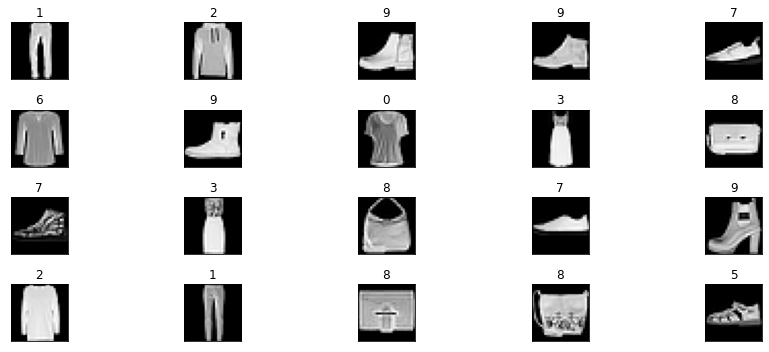

In [ ]:
dataiter = iter(trainloader)
images,labels = dataiter.next()
print(images[0].shape)
fig = plt.figure(figsize = (15,5))
for idx in range(20):
  ax = fig.add_subplot(4, 5, idx+1, xticks=[], yticks=[])
  ax.imshow(np.squeeze(images[idx]), cmap='gray')
  ax.set_title(labels[idx].item())
  fig.tight_layout()

In [ ]:
# Generator
class Generator(nn.Module):
  def __init__(self):
    super(Generator,self).__init__()
    self.fc1 = nn.Linear(100,7*7*256)
    self.upsample1 = nn.ConvTranspose2d(256,128,kernel_size=(5,5),stride=(1,1),padding=(2,2))
    self.upsample2 = nn.ConvTranspose2d(128,64,kernel_size=(5,5),stride=(2,2),padding=(2,2))
    self.upsample3 = nn.ConvTranspose2d(64,1,kernel_size=(4,4),stride=(2,2))
    # self.bn1 = torch.nn.BatchNorm1d(7*7*256)
    # self.bn2 = torch.nn.BatchNorm2d(128)
    # self.bn3 = torch.nn.BatchNorm2d(64)
    self.dropout = nn.Dropout(0.3)
  def forward(self,x):
    bs = x.shape[0]
    x  = self.fc1(x)
    # x = self.bn1(x)
    x = F.leaky_relu(x)
    # x = self.dropout(x)
    x = torch.reshape(x,(bs,256,7,7))
    x = self.upsample1(x)
    # x = self.bn2(x)
    x = F.leaky_relu(x)
    # x = self.dropout(x)
    x = self.upsample2(x)
    # x = self.bn3(x)
    x = F.leaky_relu(x)
    # x = self.dropout(x)
    x = self.upsample3(x)
    return x

In [ ]:
generator = Generator()
generator.to(device)

Generator(
  (fc1): Linear(in_features=100, out_features=12544, bias=True)
  (upsample1): ConvTranspose2d(256, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (upsample2): ConvTranspose2d(128, 64, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
  (upsample3): ConvTranspose2d(64, 1, kernel_size=(4, 4), stride=(2, 2))
  (dropout): Dropout(p=0.3, inplace=False)
)

In [ ]:
z = torch.normal(mean = 0, std = 1,size=(1,100)).to(device)
generator.eval()
print(z.shape)
op = generator.forward(z).detach()
print(op.shape)

torch.Size([1, 100])
torch.Size([1, 1, 28, 28])


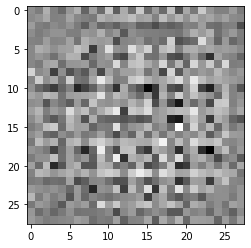

In [ ]:
plt.imshow(op.to('cpu')[0, 0, :, :], cmap='gray')

In [ ]:
class Discriminator(nn.Module):
  def __init__(self):
    super(Discriminator,self).__init__()
    self.conv1  = nn.Conv2d(1,64,kernel_size=(5,5),stride=(2,2),padding = (2,2))
    self.conv2 = nn.Conv2d(64,128,kernel_size=(5,5),stride=(2,2),padding=(2,2))
    self.dropout = nn.Dropout(0.3)
    self.fc1 = nn.Linear(6272,1)
  def forward(self,x):
    x = self.conv1(x)
    x = F.leaky_relu(x)
    x = self.dropout(x)
    x = self.conv2(x)
    x = F.leaky_relu(x)
    x = self.dropout(x)
    x = torch.flatten(x,start_dim = 1 )
    x = self.fc1(x)
    return torch.sigmoid(x)

In [ ]:
discrim = Discriminator()
discrim.to(device)

Discriminator(
  (conv1): Conv2d(1, 64, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
  (conv2): Conv2d(64, 128, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
  (dropout): Dropout(p=0.3, inplace=False)
  (fc1): Linear(in_features=6272, out_features=1, bias=True)
)

In [ ]:
img = images[0]
print(img.shape)
discrim.eval()
op = discrim.forward(img.to(device).reshape(1,1,28,28))
print(op)

torch.Size([1, 28, 28])
tensor([[0.5120]], grad_fn=<SigmoidBackward0>)


In [ ]:
criterion = nn.BCELoss().to(device)

In [ ]:
g_optim = optim.Adam(generator.parameters(),lr = 0.001)
d_optim = optim.RMSprop(discrim.parameters(),lr = 0.005)

In [ ]:
def generator_loss(fake_output):
  return criterion(fake_output,torch.ones_like(fake_output))

In [ ]:
def discriminator_loss(real_output,fake_output):
  real_loss = criterion(real_output,torch.ones_like(real_output))
  fake_loss = criterion(fake_output,torch.zeros_like(fake_output))
  return (real_loss+fake_loss)

In [ ]:
seed = torch.normal(mean = 0, std = 1,size=(batch_size,100))
print(seed.shape)

torch.Size([128, 100])


In [ ]:
def D_train(x):
    discrim.zero_grad()
    bs = x.shape[0]
    x_real, y_real = x, torch.ones(bs, 1)
    x_real, y_real = Variable(x_real.to(device)), Variable(y_real.to(device))
    D_output = discrim(x_real)
    D_real_loss = criterion(D_output, y_real)
    D_real_score = D_output
    z = Variable(torch.randn(bs, 100).to(device))
    x_fake, y_fake = generator(z), Variable(torch.zeros(bs, 1).to(device))
    D_output = discrim(x_fake)
    D_fake_loss = criterion(D_output, y_fake)
    D_fake_score = D_output
    D_loss = D_real_loss + D_fake_loss
    D_loss.backward()
    d_optim.step()
    return  D_loss.data.item()

In [ ]:
def G_train(x):
    generator.zero_grad()
    bs = x.shape[0]
    z = Variable(torch.randn(bs, 100).to(device))
    y = Variable(torch.ones(bs, 1).to(device))

    G_output = generator(z)
    D_output = discrim(G_output)
    G_loss = criterion(D_output, y)
    G_loss.backward()
    g_optim.step()
    return G_loss.data.item()

In [ ]:
d_loss = []
g_loss = []
k = 4
discrim.train()
generator.train()
for epoch in range(0,10):
  d_loss_curr,g_loss_curr = 0,0
  for images,labels in trainloader:
    temp_d_loss = 0
    for rep in range(k):
      d_optim.zero_grad()
      discrim.train()
      generator.eval()
      real_output = discrim(images.to(device))
      noise = torch.normal(mean=0,std=1,size=(batch_size,100)).to(device)
      fake_images = generator(noise).to(device)
      fake_output = discrim(fake_images)
      dis_loss = discriminator_loss(real_output,fake_output)
      dis_loss.backward()
      d_optim.step()
      temp_d_loss += dis_loss
    temp_d_loss /= k
    d_loss_curr += temp_d_loss
    g_optim.zero_grad()
    generator.train()
    discrim.eval()
    z = torch.normal(mean = 0, std = 1,size=(batch_size,100)).to(device)
    gz = generator(z)
    fake_output_gen = discrim(gz)
    gen_loss = generator_loss(fake_output_gen)
    g_loss_curr += gen_loss
    gen_loss.backward()
    g_optim.step()
  g_loss.append(int(g_loss_curr))
  d_loss.append(int(d_loss_curr))
  print("Epoch:",epoch,"Discriminator Loss:",int(d_loss_curr), "Generator_loss:",int(g_loss_curr))

Epoch: 0 Discriminator Loss: 46875 Generator_loss: 0


KeyboardInterrupt: ignored

In [ ]:
n_epoch = 10
d_loss = []
g_loss = []
discrim.train()
generator.train()
for epoch in range(1, n_epoch+1):           
    D_losses, G_losses = [], []
    for batch_idx, (x, _) in enumerate(trainloader):
        D_losses.append(D_train(x))
        G_losses.append(G_train(x))
    d_loss.append(torch.mean(torch.FloatTensor(D_losses)))
    g_loss.append(torch.mean(torch.FloatTensor(G_losses)))
    print('[%d/%d]: loss_d: %.3f, loss_g: %.3f' % (
            (epoch), n_epoch, torch.mean(torch.FloatTensor(D_losses)), torch.mean(torch.FloatTensor(G_losses))))

KeyboardInterrupt: ignored